In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('train.csv')
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [4]:
import seaborn as sns
def get_boxplot(X, columns=[]):
  for i in columns:
    sns.boxplot(x=X[i])
  pass 

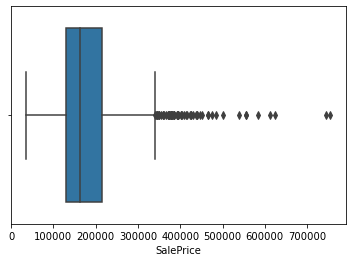

In [5]:
get_boxplot(data,columns=['SalePrice'])

In [6]:
data['SalePrice'] = np.log(data['SalePrice'])

In [7]:
#Находим категориальные признаки
cat_feat = list(data.dtypes[data.dtypes == object].index)

#закодируем пропущенные значений строкой, факт пропущенного значения тоже может нести в себе информацию
data[cat_feat] = data[cat_feat].fillna('nan')

#отфильтруем непрерывные признаки
num_feat = [f for f in data if f not in (cat_feat + ['Id', 'SalePrice'])]

In [8]:
#clustering
#data[(data['SalePrice']< 12)]=1.
#data[(data['SalePrice']> 11)&(data['SalePrice']<= 12)]=2.
#data[(data['SalePrice']> 12)&(data['SalePrice']<= 13)]=3.
#data[(data['SalePrice']> 11)]=2.


In [9]:
data.SalePrice[(data['SalePrice']< 12)] = 1
data.SalePrice[(data['SalePrice']>= 12)] = 2

In [10]:

from sklearn.model_selection import StratifiedShuffleSplit


In [11]:
# Разбиваем на train/test
splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.3, random_state=55)

for train_index, test_index in splitter.split(data, data.SalePrice):
    d_train = data.iloc[train_index]
    d_test = data.iloc[test_index]
    
    y_train = data['SalePrice'].iloc[train_index]
    y_test = data['SalePrice'].iloc[test_index]

In [12]:
# Создаем дамми-переменные для категорий
dummy_train = pd.get_dummies(d_train[cat_feat], columns=cat_feat)
dummy_test = pd.get_dummies(d_test[cat_feat], columns=cat_feat)

dummy_cols = list(set(dummy_train) & set(dummy_test))

dummy_train = dummy_train[dummy_cols]
dummy_test = dummy_test[dummy_cols]


# Заменяем пропуски на специальное значение -999, чтобы деревья могли их отличить
X_train = pd.concat([d_train[num_feat].fillna(-999),
                     dummy_train], axis=1)

X_test = pd.concat([d_test[num_feat].fillna(-999),
                     dummy_test], axis=1)

In [13]:
from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier(n_estimators=10, max_depth=10, min_samples_leaf=20, max_features=0.5, n_jobs=-1)
clf_rf.fit(X_train, y_train) 

RandomForestClassifier(max_depth=10, max_features=0.5, min_samples_leaf=20,
                       n_estimators=10, n_jobs=-1)

In [15]:
y_pred_train_rf = clf_rf.predict_proba(X_train)[:, 1]
y_pred_test_rf = clf_rf.predict_proba(X_test)[:, 1]

In [16]:
imp = pd.Series(clf_rf.feature_importances_)
imp.sort_values(ascending=False)

15     0.324005
5      0.152838
18     0.125201
3      0.124118
2      0.034976
         ...   
169    0.000000
168    0.000000
167    0.000000
166    0.000000
134    0.000000
Length: 269, dtype: float64

In [17]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf_rf, X_test, y_test, cv=5)
scores

array([0.88636364, 0.88636364, 0.85227273, 0.83908046, 0.87356322])

In [18]:
scores.mean()

0.8675287356321839

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import StackingClassifier


classifier = StackingClassifier(
    [
        ('lr', LogisticRegression(max_iter=100000)),
        ('dt', DecisionTreeClassifier())
    ],
LogisticRegression())



In [20]:
classifier.fit(X_train, y_train)

StackingClassifier(estimators=[('lr', LogisticRegression(max_iter=100000)),
                               ('dt', DecisionTreeClassifier())],
                   final_estimator=LogisticRegression())

In [21]:
StackingClassifier(estimators=[('lr', LogisticRegression(max_iter=100000)),
                               ('dt', DecisionTreeClassifier())],
                   final_estimator=LogisticRegression())

StackingClassifier(estimators=[('lr', LogisticRegression(max_iter=100000)),
                               ('dt', DecisionTreeClassifier())],
                   final_estimator=LogisticRegression())

In [22]:
classifier.named_estimators_['lr']

LogisticRegression(max_iter=100000)

In [23]:
y_pred_proba_lr = classifier.named_estimators_['lr'].predict_proba(X_test)[:,1]

In [24]:
y_pred_proba_dt = classifier.named_estimators_['dt'].predict_proba(X_test)[:,1]

In [25]:
y_pred_proba = classifier.predict_proba(X_test)[:,1]

In [26]:
classifier.final_estimator_

LogisticRegression()

<AxesSubplot:>

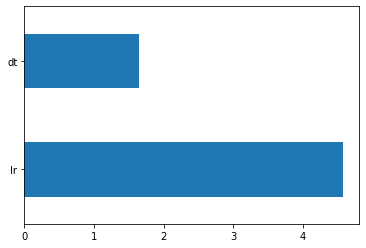

In [27]:
pd.Series(classifier.final_estimator_.coef_.flatten(), index=classifier.named_estimators_.keys()).plot(kind='barh')

In [28]:
scores = cross_val_score(classifier, X_test, y_test, cv=5)
scores

array([0.875     , 0.89772727, 0.86363636, 0.89655172, 0.90804598])

In [29]:
scores.mean()

0.8881922675026124